## Disclaimer: The training and testing data are not included in the submission file because it is too large to submit. Please include the promotion_classifier_data in the current directory before running the notebook.

# Setup

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import pythainlp
from pythainlp import word_tokenize
from pythainlp.corpus.common import thai_stopwords
from pythainlp.util import normalize
import emoji
import string
import cv2
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Flatten
import efficientnet.tfkeras as efn

# Data Preparation

In [2]:
data_csv_path = os.path.join("promotion_classifier_data", "training_set.csv")
data = pd.read_csv(data_csv_path)

In [3]:
def get_path(promotion_id, type_of_image):
    return os.path.join("promotion_classifier_data", type_of_image, promotion_id) + ".jpg"

def get_img(path_to_img):
    return mpimg.imread(path_to_img)

def resize_img(img, shape):
    return cv2.resize(img, (shape[1], shape[0]), interpolation=cv2.INTER_CUBIC)

def remove_punctuation(text):
    text_without_punctuation = ""
    punctuations = []
    punctuations[:0] = string.punctuation
    
    for char in text:
        if not char in punctuations:
            text_without_punctuation += char
            
    return text_without_punctuation
            
def remove_emoji(text):
    return emoji.get_emoji_regexp().sub("", text)

def remove_stopwords(list_of_description):
    tokenized_without_stopwords = []
    stopwords = list(thai_stopwords())
    for word in list_of_description:
        if not (word in stopwords or "\n" in word):
            tokenized_without_stopwords.append(word)
            
    return tokenized_without_stopwords

def transform_description(text):
    without_punctuation_description = remove_punctuation(text)
    normalized_description = normalize(without_punctuation_description)
    emojiless_description = remove_emoji(normalized_description)
    tokenized_description = word_tokenize(emojiless_description, keep_whitespace=False)
    without_stopwords_description = remove_stopwords(tokenized_description)
    
    return without_stopwords_description

def transform_img(promotion_id, type_of_image):
    path_to_img = get_path(promotion_id, type_of_image)
    img = get_img(path_to_img)
    resized_img = resize_img(img, (299, 299))
    
    return resized_img

def dataframe_pipeline(df, type_of_image):
    df = df.fillna("")
    df.loc[:, "tocount_description"] = df["description"].apply(word_tokenize)
    df.loc[:, "word_count"] = df["tocount_description"].apply(len)
    df.loc[:, "img_pixels"] = df["PromotionId"].apply(transform_img, type_of_image=type_of_image)
    
    return df

In [4]:
data = dataframe_pipeline(data, "training_images")

data.head(10)

,PromotionId,description,bad,tocount_description,word_count,img_pixels
0,1NWLAzBwCUadj2dLNYVrTib3XuTL0T,ซาลาปัง จัดใหญ่แทนใจคนที่คุณรัก,0,"[ซา, ลา, ปัง, , จัด, ใหญ่, แทน, ใจ, คน, ที่, ...",12,"[[[225, 226, 231], [225, 226, 231], [225, 226,..."
1,1NWLD3dp7tdq34WkgzQGLiPQM7dFC5,ทะเลทะลัก!! สุดยอดบุฟเฟ่ต์ทะเล ที่คุณไม่ควรพลา...,0,"[ทะเล, ทะลัก, !!, , สุดยอด, บุฟเฟ่ต์, ทะเล, ...",80,"[[[218, 159, 119], [233, 161, 123], [231, 147,..."
2,1NWLCHgnVeBb2TIup13b1RSOLOl3Cq,บัตรสมาชิก By อ.กุ้งเผาโคราช\n\n\n\nบัตรสมาชิก...,1,"[บัตรสมาชิก, , By, , อ., กุ้ง, เผา, โคราช, \...",160,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
3,1NWLC9rEila7y7EyYKPp17zCMkjHs2,สาวกเพื่อสุขภาพครับ,1,"[สาวก, เพื่อ, สุขภาพ, ครับ]",4,"[[[110, 84, 57], [98, 38, 28], [19, 13, 11], [..."
4,1NWLCUe1qEBZtZEwInmjdBoce8XBF2,วันเกิด แจ้งพนักงาน รับฟรีฮันนีโทส1จานค่ะ\n\n\n\n,0,"[วันเกิด, , แจ้ง, พนักงาน, , รับ, ฟรี, ฮันนี...",16,"[[[4, 4, 2], [6, 6, 4], [7, 7, 5], [7, 7, 5], ..."
5,1NWLC9g0nfGqwDLV0jzcb8Q6Ys3ZBT,ร้านน่ารัก ๆ,1,"[ร้าน, น่ารัก, , ๆ]",4,"[[[19, 21, 16], [79, 82, 75], [129, 132, 123],..."
6,1NWLAyIft6FUB8MT4aK0IKjLsaN70y,โปรโมชั่นวันเกิด แสดงบัตรประจำตัวประชาชนตรงกับ...,0,"[โปรโมชั่น, วันเกิด, , แสดง, บัตรประจำตัวประช...",22,"[[[252, 206, 69], [252, 206, 69], [252, 206, 6..."
7,1NWLBEnYhTJOdIuQCdW8RgVh5yXBDZ,ชานม,1,"[ชา, นม]",2,"[[[59, 55, 56], [59, 55, 56], [53, 49, 49], [4..."
8,1NWLDLTHIVeRaUZVvLobx8BeU4nrw1,ซื้อ 10 แก้ว ฟรี 1 แก้วค่ะ 😁,1,"[ซื้อ, , 10, , แก้ว, , ฟรี, , 1, , แก้ว, ...",14,"[[[202, 205, 214], [203, 206, 213], [204, 207,..."
9,1NWLCTNe0amJfILF8cozH9UUZEEmfR,สลัดเป็ด ซอสส้ม\n\n\n,1,"[สลัด, เป็ด, , ซอส, ส้ม, \n, \n, \n]",8,"[[[161, 150, 141], [140, 126, 111], [140, 124,..."


# Simple Recommendation System

### Recommendation for description data

Transform the data using CountVectorizer and cosine_similarity.

The idea is to transform the the description text into a vector so that we can find the similarity of each vector based on cosine.

In [5]:
corpus = [x for x in data["description"].values]
vectorizer = CountVectorizer(analyzer = transform_description)
count_matrix = vectorizer.fit_transform(corpus)
cosine_sim_text = cosine_similarity(count_matrix)

A function that get top 5 result that are similar to the input promotion index.

In [6]:
def get_text_recommendation(promotion_idx):
    recommended_promotions = []
    score_series = pd.Series(cosine_sim_text[promotion_idx]).sort_values(ascending = False)
    top_5_indices = list(score_series.iloc[1:6].index)
    
    for i in top_5_indices:
        recommended_promotions.append(data['description'].values[i])
        
    return recommended_promotions

Shows the original description and the top 5 recommendations based on that original description. You can change the original_description_idx variable to try with different descriptions.

In [7]:
original_description_idx = 14
print("Original: ", data.loc[original_description_idx, "description"])
print("Recommended: ", get_text_recommendation(original_description_idx))

Original:  ยำหัวปลี กับข้าวเกรียบ
Recommended:  ['บะหมี่แห้งยำ', 'ยำวุ้นเส้นกุ้ง\n\n\n', 'เส้นปลายำบก\n\n\n', 'เส้นปลาโฟยำ', 'ยำแซลมอน 99฿']


### Recommendation for image data

The code below changes the image input into the shape that the deep learning model wants, which is (None, 299, 299, 3). The code below takes about 4-5 minutes to run.

In [8]:
img_input = data["img_pixels"][0].reshape(1, 299, 299, 3)
for idx, img in enumerate(data["img_pixels"].values):
    if idx != 0:
        img_input = np.concatenate((img_input, img.reshape(1, 299, 299, 3)))

Setup an efficientnet B1 architecture to extract the features of each images.

In [9]:
height = 299
width = 299
channels = 3
input_shape = (height, width, channels)

efnb1 = efn.EfficientNetB1(weights='imagenet', include_top=False, input_shape=input_shape)

model = Sequential()
model.add(efnb1)
model.add(Flatten())

model.summary()

2022-01-03 20:37:47.011869: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b1 (Functional  (None, 10, 10, 1280)     6575232   
 )                                                               
                                                                 
 flatten (Flatten)           (None, 128000)            0         
                                                                 
Total params: 6,575,232
Trainable params: 6,513,184
Non-trainable params: 62,048
_________________________________________________________________


Extract the features of each images and use cosine similarity to find similar images in the vector space. The below code takes about 2 minutes to run on my machine.

In [10]:
imgs_features = model.predict(img_input)
cosine_sim_img = cosine_similarity(imgs_features)

A function that get top 5 result that are similar to the input promotion index.

In [11]:
def get_img_recommendation(promotion_idx):
    recommended_promotions = []
    score_series = pd.Series(cosine_sim_img[promotion_idx]).sort_values(ascending = False)
    top_5_indices = list(score_series.iloc[1:6].index)
    
    for i in top_5_indices:
        recommended_promotions.append(data['img_pixels'].values[i])
        
    return recommended_promotions

Shows the original image and the top 5 recommendations based on that original image. You can change the original_img_idx variable to try with different images.

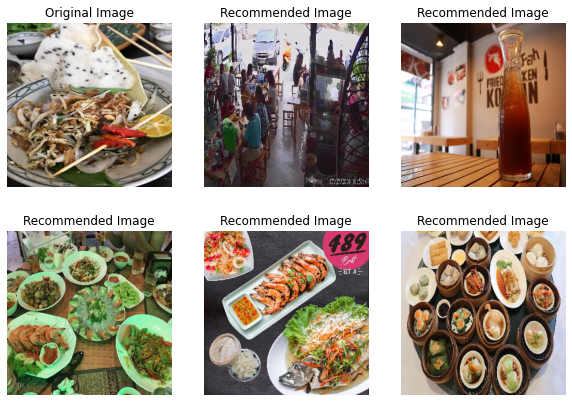

In [12]:
original_img_idx = 14
recommended_promotions = get_img_recommendation(original_img_idx)
fig = plt.figure(figsize=(10, 7))

rows = 2
columns = 3

fig.add_subplot(rows, columns, 1)
  
plt.imshow(data.loc[original_img_idx, "img_pixels"])
plt.axis('off')
plt.title("Original Image")

img_idx = 2
for img in recommended_promotions:
    fig.add_subplot(rows, columns, img_idx)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Recommended Image")
    img_idx += 1

# Conclusion

Since this is a simple prototype, the text recommendation system seems to be better than the image recommendation system. So if this is a real world project that has to be done in around 10 days then I would weight the recommended promotions from the description more than the images.